In [1]:
import os
import sys
import time
import glob
import json
import pytz
import numpy as np
import logging
import seaborn as sns
import argparse
import datetime
import graphviz
import networkx as nx
import matplotlib.pyplot as plt

import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々
import torch.backends.cudnn as cudnn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# utils

## other

In [3]:
def argspace(*funcs, **kwds):
  def deco(f):
    def inner(**ikwds):
      for g in funcs:
        kwds.update(g())
      kwds.update(ikwds)
      return f(argparse.Namespace(**kwds))
    return inner
  return deco

In [4]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [5]:
class Singleton(object):
  def __new__(cls, *args, **kargs):
    if not hasattr(cls, "_instance"):
      cls._instance = super(Singleton, cls).__new__(cls)
    return cls._instance

In [6]:
class Experiment(Singleton):
  def __init__(self):
    if not hasattr(self, 'func'):
      self.func = {}
  
  def _store(self, key, f, order):
    self.func.setdefault(key, {})
    self.func[key].update({f.__name__:(order, f)})

  def __call__(self, key):
    def f(*args, **kwds):
      funcs = sorted(self.func[key].values(), key=lambda x: x[0])
      return [g(*args, **kwds) for _, g in funcs]
    return f

  def event(*key, order=0):
    def d(f):
      for k in key:
        Experiment()._store(k, f, order)
      def inner(*args, **kwds):
        return f(*args, **kwds)
      return inner
    return d
  
  def reset():
    Experiment().func = {}

## metrics

In [7]:
def accuracy(output, target, topk=(1,)):
  maxk = max(topk)
  batch_size = target.size(0)

  _, pred = output.topk(maxk, 1, True, True)
  pred = pred.t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))

  res = []
  for k in topk:
    correct_k = correct[:k].view(-1).float().sum(0)
    res.append(correct_k.mul_(100.0/batch_size))
  return res

In [8]:
class AvgrageMeter(object):

  def __init__(self):
    self.reset()

  def reset(self):
    self.avg = 0
    self.sum = 0
    self.cnt = 0

  def update(self, val, n=1):
    self.sum += val * n
    self.cnt += n
    self.avg = self.sum / self.cnt

In [9]:
class Metrics():
  def __init__(self, model, dataloader):
    self._run(model, dataloader)
    self.epsilon = 1e-7
  
  @torch.no_grad()
  def _run(self, model, dataloader):
    data, target = next(iter(dataloader))
    device =  next(model.parameters()).device
    print(device)
    num = target.max().long() + 1
    cm = torch.zeros(num, num).to(device)

    for i, (data, target) in enumerate(dataloader):
      data = data.to(device)
      target = target.to(device)
      outputs = model(data)
      _, preds = torch.max(outputs, 1)
      for t, p in zip(target.view(-1), preds.view(-1)):
        cm[t.long(), p.long()] += 1

    self.matrix = cm
    self.dim = num
    self.sum0 = self.matrix.sum(0)
    self.sum1 = self.matrix.sum(1)
    self.sum = self.matrix.sum()

  def confusion_matrix(self):
    return self.matrix

  def TP(self, index):
    return self.matrix[index][index]

  def FN(self, index):
    return self.sum1[index] - self.TP(index)

  def FP(self, index):
    return self.sum0[index] - self.TP(index)

  def TN(self, index):
    return self.sum - self.TP(index) - self.FN(index) - self.FP(index)

  def _sum(self, F):
    return sum(F(i) for i in range(self.dim))
    
  def _micro(self, F, G):
    return self._sum(F) / (self._sum(F) + self._sum(G) + self.epsilon)

  def _macro(self, F, G):
    return sum(F(i) / (F(i) + G(i) + self.epsilon) for i in range(self.dim)) / self.dim

  def _switch(self, F, G, micro):
    return (self._micro(F, G) if micro else self._macro(F, G))

  def accuracy(self, micro=True):
    return (self._sum(self.TP) / self.sum if micro else 
            (sum(self.TP(i) / self.sum1 for i in range(self.dim)) / self.dim).mean())

  def precision(self, micro=True):
    return self._switch(self.TP, self.FP, micro)

  def recall(self, micro=True):
    return self._switch(self.TP, self.FN, micro)

  def specificity(self, micro=True):
    return self._switch(self.TN, self.FP, micro)

  def f_measure(self, micro=True):
    p, r = self.precision(micro), self.recall(micro)
    return 2 * p * r / (p + r + self.epsilon)

  def print(self):
    print(self.confusion_matrix())
    print("accuracy ", self.accuracy(), self.accuracy(micro=False))
    print("precision ", self.precision(), self.precision(micro=False))
    print("recall ", self.recall(), self.recall(micro=False))
    print("specificity ", self.specificity(), self.specificity(micro=False))
    print("f_measure ", self.f_measure(), self.f_measure(micro=False))

In [10]:
def count_param(model : nn.Module):
  param = model.named_parameters()
  itr = [np.prod(v.size()) for name, v in param if "auxiliary" not in name]
  return np.sum(itr)

In [11]:
from typing import Union
from collections import OrderedDict
@torch.no_grad()
def square_error(m : Union[nn.Module, OrderedDict], n : Union[nn.Module, OrderedDict]):
  m = m.parameters() if isinstance(m, nn.Module) else m.values()
  n = n.parameters() if isinstance(n, nn.Module) else n.values()
  s = [torch.sum((x - y) * (x - y)) for x, y in zip(m, n)]
  return sum(s)

## save

In [12]:
def path_with_time(path : str) -> str:
  dt_now = datetime.datetime.now(pytz.timezone('Asia/Tokyo'))
  return '{}-{}'.format(path, dt_now.strftime('%Y-%m-%d_%H-%M-%S'))

In [13]:
def create_exp_dir(path, scripts_to_save=None):
  if not os.path.exists(path):
    os.mkdir(path)
  print('Experiment dir : {}'.format(path))

  if scripts_to_save is not None:
    os.mkdir(os.path.join(path, 'scripts'))
    for script in scripts_to_save:
      dst_file = os.path.join(path, 'scripts', os.path.basename(script))
      shutil.copyfile(script, dst_file)

In [14]:
def init_logging(save_path):
  class Formatter(logging.Formatter):
      """override logging.Formatter to use an aware datetime object"""
      def converter(self, timestamp):
          dt = datetime.datetime.fromtimestamp(timestamp)
          tzinfo = pytz.timezone('Asia/Tokyo')
          return tzinfo.localize(dt)
          
      def formatTime(self, record, datefmt=None):
          dt = self.converter(record.created)
          if datefmt:
              s = dt.strftime(datefmt)
          else:
              try:
                  s = dt.isoformat(timespec='milliseconds')
              except TypeError:
                  s = dt.isoformat()
          return s

  log_format = '%(asctime)s %(message)s'
  logging.basicConfig(stream=sys.stdout, level=logging.INFO,
      format=log_format, datefmt='%m/%d %I:%M:%S %p')
  fh = logging.FileHandler(os.path.join(save_path, 'log.txt'))
  fh.setFormatter(Formatter(log_format))
  logging.getLogger().addHandler(fh)

In [15]:
def save_dir(dir : str, drivepath = './drive/My Drive/ml'):
  if not dir: return

  import subprocess
  res = subprocess.run(["cp", "-r", "./" + dir, drivepath], stdout=subprocess.PIPE)
  sys.stdout.write(res.stdout)

In [16]:
class Store():
  def __init__(self, dir="result", name="log", fig=[]):
    self.dict = {}
    self.dir = dir
    self.name = name
    self.fig = fig
  
  def add(self, name, value):
    if not name in self.dict:
      self.dict[name] = []
    self.dict[name].append(value)
  
  def apply(self, name, func):
    if not name in self.dict:
      self.dict[name] = []
    return func(self.dict[name])

  def update(self, store : 'Store'):
    self.dict.update(store.dict)

  def save(self):
    self.save_log()
    for metrix, x, y in self.fig:
      self.save_fig(metrix, x, y)

  def save_log(self, name=None):
    name = name if name else self.name
    path = os.path.join(self.dir, name + ".txt")
    with open(path, mode='w') as f:
      f.write("%s" % self.dict)

  def save_fig(self, metrix, xlabel, ylabel, show=True):
    fig = plt.figure()

    if type(metrix) is str:
      times = len(self.dict[metrix])
      plt.plot(np.arange(times), self.dict[metrix])
    else :
      times = len(self.dict[metrix[0]])
      for m in metrix:
        plt.plot(np.arange(times), self.dict[m], label=m)
      metrix = "_".join(metrix)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    if show: plt.show()
    fig.savefig(os.path.join(self.dir, "%s_%d.png" % (metrix, times)))

  def __repr__(self):
    return "store in %s" % self.dict

In [17]:
def render_graph(graph, path):
  format = dict(
      format='png', 
      edge_attr=dict(fontsize='20', fontname="times"),
      node_attr=dict(style='filled', shape='rect', align='center', fontsize='20', height='0.5', width='0.5', penwidth='2', fontname="times"),
      engine='dot' # circo, dot, fdp, neato, osage, sfdp, twopi
  )

  dg = graphviz.Digraph(**format)

  dg.attr('node', fillcolor='dodgerblue4', fontcolor='white', fontsize='15') # coral, 
  for node in graph.nodes():
    attr = graph.nodes[node]
    label = attr['name'] if 'name' in attr else str(node)
    label += '\n(%s, %d, %d)' % (attr['channel'], 32 / attr['stride'], 32 / attr['stride'])
    dg.node(str(node), label=label)

  for (i, j) in graph.edges():
    attr = graph.edges[i, j]
    label = attr['module']
    label = ""
    style = 'bold' if attr['module'] == 'forward' else 'dashed'
    dg.edge(str(i), str(j), label=label, style=style)

  dg.render(path)
  return dg

In [18]:
def save_heatmap(data : torch.tensor, path, format='1.2f'):
  plt.figure()
  data = data.detach().cpu().clone().numpy()
  sns.heatmap(data, annot=True, fmt=format)
  plt.savefig(path)
  plt.close('all')

# dataset

In [19]:
def load_dataset(train=2000, test=500, valid=0):
  #画像の変形処理
  transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
  ])

  transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
  ])

  dataset = torchvision.datasets.CIFAR10
  kwargs = {"root" : "./data", "download" : True}

  #CIFAR-10のtrain, testsetのロード
  trainset = dataset(train=True, transform=transform, **kwargs)
  testset = dataset(train=False, transform=transform_test, **kwargs)
  
  trainset, validset, _ = torch.utils.data.random_split(trainset, [train, valid, 50000-train-valid])
  testset, _ = torch.utils.data.random_split(testset, [test, 10000-test])
  return argparse.Namespace(train=trainset, test=testset, valid=validset)

In [20]:
def load_dataloader(args):
  kwargs = {'num_workers': 1, 'pin_memory': True} if args.use_cuda else {}
  args.valid_size = args.valid_size if args.valid_size else 0
  sets = load_dataset(train=args.train_size, test=args.test_size, valid=args.valid_size)
  trainloader = torch.utils.data.DataLoader(sets.train, batch_size=args.batch_size, shuffle=True, **kwargs)
  validloader = torch.utils.data.DataLoader(sets.valid, batch_size=args.batch_size, shuffle=True, **kwargs) if args.valid_size else None
  testloader = torch.utils.data.DataLoader(sets.test, batch_size=args.batch_size, shuffle=False, **kwargs)
  return argparse.Namespace(train=trainloader, test=testloader, valid=validloader)

# model

## sampler

In [21]:
class ArchitectureSampler():
  def __call__(self, graph : nx.DiGraph, alpha : torch.Tensor) -> nx.DiGraph:
    return self.graph(graph, alpha)

In [22]:
class MaxSampler(ArchitectureSampler):
  def graph(self, graph, alpha):
    G = nx.DiGraph(graph)
    n = G.number_of_nodes()

    for j in range(1, n):
      edges = [(i, j) for i in G.predecessors(j)]
      alphas = [alpha[i, j].item() for i, j in edges]
      edge_num = round(sum(alphas))
      disable = sorted(zip(edges, alphas), key=lambda x: x[-1])[:-edge_num]
      G.remove_edges_from([i for i, _ in disable])

    return G

In [23]:
class EdgewiseSampler(ArchitectureSampler):
  def graph(self, graph, alpha):
    G = nx.DiGraph(graph)
    n = G.number_of_nodes()

    for j in range(1, n):
      edges = [(i, j) for i in G.predecessors(j)]
      alphas = [alpha[i, j].item() for i, j in edges]
      disable = [(e, a) for e, a in zip(edges, alphas) if round(a) < 1]
      G.remove_edges_from([i for i, _ in disable])

    return G

In [24]:
class ForwardSampler(ArchitectureSampler):
  def graph(self, graph, alpha):
    G = nx.DiGraph(graph)
    n = G.number_of_nodes()

    for j in range(1, n):
      edges = [(i, j) for i in G.predecessors(j) if not i + 1 == j]
      G.remove_edges_from(edges)

    return G

In [25]:
class StrideCutSampler(ArchitectureSampler):
  def __init__(self, stride_max=8):
    assert stride_max >= 1
    self.stride = stride_max

  def graph(self, graph, alpha):
    G = nx.DiGraph(graph)
    n = G.number_of_nodes()

    for j in range(1, n):
      edges = [(i, j) for i in G.predecessors(j) if G.edges[i, j]['stride'] > self.stride]
      G.remove_edges_from(edges)

    return G

In [26]:
# args = {'gene':'VGG19', 'stride_max':2}
# model = load_model(dir="exp_vgg19_beta_zero-2020-10-07_12-10-48", **args)
# g = model.graph
# sampler = EdgewiseSampler()
# h = model.sampled_graph(sampler)
# render_graph(h, 'graph')
# # nx.graph_edit_distance(g, h)

## component

In [27]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [28]:
class FactorizedReduce(nn.Module):
  def __init__(self, channel_in, channel_out, stride, affine=True):
    super(FactorizedReduce, self).__init__()
    assert channel_out % stride == 0
    
    self.convs = nn.ModuleList([
      nn.Conv2d(channel_in, channel_out // stride, 1, stride=stride, padding=0, bias=False)
      for _ in range(stride)
    ])
    self.bn = nn.BatchNorm2d(channel_out, affine=affine)

  def forward(self, x):
    # strideの偶奇による情報ロスを防ぐ
    out = torch.cat([conv(x[:,:,i:,i:]) for i, conv in enumerate(self.convs)], dim=1)
    out = self.bn(out)
    return out

In [29]:
class Shortcut(nn.Module):
  def __init__(self, in_channel, out_channel, stride):
    super(Shortcut, self).__init__()
    self.f = self._shortcut(in_channel, out_channel, stride)

  def forward(self, x):
    return self.f(x)

  def _shortcut(self, channel_in, channel_out, stride):
    if stride > 1:
      return FactorizedReduce(channel_in, channel_out, stride)
    elif channel_in != channel_out:
      return nn.Conv2d(channel_in, channel_out, 
                       kernel_size=1, stride=stride, padding=0)
    else:
      return lambda x: x

In [30]:
class Block(nn.Module):
  def __init__(self, graph, index):
    super(Block, self).__init__()
    node = graph.nodes[index]
    edges = [(i, index, graph.edges[i, index]) for i in graph.predecessors(index)]

    self.index = index
    self.indices = [i for i, _, _ in edges]
    self.edges = nn.ModuleList([self._build_module(s) for i, j, s in edges])

    process = [nn.ReLU(inplace=True)]
    if node['pool']: process += [nn.MaxPool2d(kernel_size=2, stride=2)]
    self.post_process = nn.Sequential(*process)

  def _build_module(self, setting):
    module = setting['module']
    in_channel, out_channel = setting['channel']
    stride = setting['stride']
    if module == 'forward':
      return nn.Sequential(
          nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
          nn.BatchNorm2d(out_channel)
          )
    elif module == 'shortcut':
      return Shortcut(in_channel, out_channel, stride)
    else:
      raise ValueError("module name")

  def forward(self, inputs, alpha):
    output = sum(alpha[i] * F(inputs[i]) for i, F in zip(self.indices, self.edges))
    return self.post_process(output)

## network

In [31]:
# 前提条件 : make graph, modules(Block, pool, ...)
# 拘束条件 : alpha sofmax
class Network(nn.Module):
  def __init__(self, gene, graph=None, preprocess : ArchitectureSampler=None):
    super(Network, self).__init__()
    self.gene = gene
    self.evaluate = bool(graph)
    self.graph = graph if graph else self._make_graph(gene)
    self.graph = preprocess(self.graph, None) if preprocess else self.graph

    self.blocks = nn.ModuleList(self._make_blocks(self.graph))
    self.pool = nn.AvgPool2d(kernel_size=1, stride=1)
    self.classifier = nn.Linear(512, 10)

  def _make_graph(self, gene, color_channel=3):
    
    def _decode_gene(gene):
      ch, st = [], []
      for g in gene:
        if g == 'M':
          st[-1] *= 2
        else :
          ch += [g]
          st += [1]
      return ch, st

    def __pi(array):
      r = []
      s = 1
      for q in array:
        s *= q
        r += [s]
      return r

    channel, stride = _decode_gene(gene)
    channel = [color_channel] + channel
    stride = [1] + stride
    s_stride = __pi(stride)

    n = len(channel)
    nodes = [(i, {'channel':channel[i], 'stride':s_stride[i], 'pool':stride[i]>1}) for i in range(n)]
    nodes[0][-1].update({'name':'input'})
    edges = [(i, j, {}) for i in range(n) for j in range(n) if i < j and not (i == 0 and j > 1)]
    for (i, j, d) in edges:
      d.update({
        'module' : 'forward' if i + 1 == j else 'shortcut', 
        'channel' : (nodes[i][-1]['channel'], nodes[j][-1]['channel']),
        'stride' : int(nodes[j-1][-1]['stride'] / nodes[i][-1]['stride'])
      })

    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G

  def _make_blocks(self, graph):
    return [Block(graph, i) for i in graph.nodes() if i > 0]

  def init_alpha(self, device):
    def _init_alpha(node_num, device, delta=1e-3):
      noise = delta * torch.randn(node_num, node_num, device=device)
      alpha = noise.clone().detach().requires_grad_(True)
      return [alpha]

    def _mask(node_num, device, name):
      mask = torch.zeros(node_num, node_num, device=device)

      for i, j in self.graph.edges():
        op = self.graph.edges[i, j]['module']
        if not op == name: continue

        mask[i, j] = 1

      return mask.t() > 0

    n = self.graph.number_of_nodes()
    self.alphas = _init_alpha(n, device)
    self.mask_s = _mask(n, device, 'shortcut')
    self.mask_f = _mask(n, device, 'forward')

    # self.alphas += [torch.ones(n, device=device, requires_grad=True)]
    self.alphas += [torch.zeros(n, device=device, requires_grad=True)]

    return self

  def normalized_alpha(self):
    alpha = torch.zeros_like(self.alphas[0])
    if self.evaluate:
      for i, j in self.graph.edges():
        alpha[j, i] = 1.0
    else:
      alpha[self.mask_f] = 1.0
      for a, raw, mask, b in zip(alpha, self.alphas[0], self.mask_s, self.normalized_beta()):
        a[mask] = b * F.softmax(raw[mask], dim=0)
    return alpha

  def normalized_beta(self):
    # f = lambda x : math.exp(x - 1) if x < 1 else math.log(x) + 1
    # return self.beta().apply_(f)
    x = self.beta()
    m = x>1
    beta = torch.zeros_like(x)
    beta[m] = torch.log(x[m]) + 1
    beta[~m] = torch.exp(x[~m] - 1)
    return beta

  def beta(self):
    return self.alphas[1]

  def sampled_graph(self, sampler : ArchitectureSampler):
    return sampler(self.graph, self.matrix_alpha())

  @torch.no_grad()
  def matrix_alpha(self, normalize=True):
    return (self.normalized_alpha() if normalize else self.alphas[0]).t()


  def forward(self, x):
    state = [x]
    alpha = self.normalized_alpha()

    for block in self.blocks:
      x = block(state, alpha[block.index])
      state += [x]

    out = self.pool(x)
    out = out.view(out.size(0), -1)
    out = self.classifier(out)
    return out

## architecture

In [32]:
class Architect():
  def __init__(self, valid_loader, model, criterion, lr, device):
    self.valid_loader = valid_loader
    self.model = model
    self.criterion = criterion
    self.optimizer = optim.Adam(model.alphas, lr=lr, betas=(0.5, 0.999), weight_decay=1e-3)
    self.device = device
    self.train = True

  def step(self):
    if not self.valid_loader: return
    if not self.train: return
    
    data_v, target_v = next(iter(self.valid_loader))
    data_v, target_v = data_v.to(self.device), target_v.to(self.device)

    self.optimizer.zero_grad()
    output = self.model(data_v)
    loss = self.criterion(output, target_v)
    loss.backward()
    self.optimizer.step()

# learning

## events

In [33]:
@Experiment.event('setup')
def setup(args):
  args.save = path_with_time(args.save)
  create_exp_dir(args.save, scripts_to_save=glob.glob('*.py'))
  init_logging(args.save)
  logging.info('kwargs %s' % args)
  
  args.start_epoch = 0

  # log init
  fig = [(["train_acc", "test_acc"], "epochs", "accuracy[%]"),
         (["train_loss", "test_loss"], "epochs", "loss")]
  store = Store(dir=args.save, name="store", fig=fig)
  args.store = store

  set_seed(args.seed)

In [34]:
@Experiment.event('setup')
def set_device(args):
  # cuda init
  args.use_cuda = torch.cuda.is_available()
  args.device = torch.device("cuda" if args.use_cuda else "cpu")

In [35]:
@Experiment.event('epoch_start')
def logging_alpha(args):
  model = args.model
  if not model.evaluate:
    logging.info('raw %s', model.matrix_alpha(normalize=False))
    logging.info('alpha %s', model.matrix_alpha())
    logging.info('beta %s', model.beta())

In [36]:
@Experiment.event('train_end')
def train_end(args, data):
  train_acc, train_obj = data
  logging.info('train_acc %f', train_acc)
  args.store.add("train_loss", train_obj)
  args.store.add("train_acc", train_acc)

In [37]:
@Experiment.event('test_end')
def test_end(args, data):
  valid_acc, valid_obj = data
  logging.info('valid_acc %f', valid_acc)
  args.store.add("test_loss", valid_obj)
  args.store.add("test_acc", valid_acc)

In [38]:
@Experiment.event('checkpoint', 'end', order=1)
def save_checkpoint(args):
  args.store.save()
  save_dir(args.save)

In [39]:
@Experiment.event('end')
def aggregate_data(args):
  store = args.store
  m = store.apply('test_acc', max)
  store.add('test_acc' + '_best', m)
  logging.info('best acc %s' % m)

In [40]:
@Experiment.event('checkpoint', 'end')
def save_model(args):
  state = {
    'model': args.model.state_dict(),
    'graph': args.model.graph,
    'alpha': args.model.alphas,
    'store': args.store,
    'epoch': args.epoch,
  }
  torch.save(state, os.path.join(args.save, 'checkpoint.pth'))

In [41]:
@Experiment.event('epoch_end')
def save_graph(args):
  path = os.path.join(args.save, 'graph')
  if not os.path.exists(path):
    os.mkdir(path)
  sampler = MaxSampler()
  graph = args.model.sampled_graph(sampler)
  torch.save(graph, os.path.join(path, 'graph_%d.pth' % args.epoch))
  render_graph(graph, os.path.join(path, 'graph_%d' % args.epoch))

In [42]:
@Experiment.event('epoch_end')
def save_alpha(args):
  path = os.path.join(args.save, 'alpha')
  if not os.path.exists(path):
    os.mkdir(path)
  save_heatmap(args.model.matrix_alpha(), os.path.join(path, 'alpha_%d.png' % args.epoch))

In [43]:
@Experiment.event('epoch_end')
def save_weight(args):
  if not args.save_weight: return

  path = os.path.join(args.save, 'model')
  if not os.path.exists(path):
    os.mkdir(path)
  torch.save(args.model.state_dict(), os.path.join(path, 'model_%d.pth' % args.epoch))

## learning

In [44]:
@argspace(retain_graph=True)
def train(args):
  objs = AvgrageMeter()
  top1 = AvgrageMeter()
  top5 = AvgrageMeter()
  args.model.train()

  for step, (input, target) in enumerate(args.dataset):
    n = input.size(0)

    input = Variable(input, requires_grad=False).to(args.device)
    target = Variable(target, requires_grad=False).to(args.device)

    args.architect.step()

    args.optimizer.zero_grad()
    logits = args.model(input)
    loss = args.criterion(logits, target)

    loss.backward(retain_graph=args.retain_graph)
    # nn.utils.clip_grad_norm(model.parameters(), args.grad_clip)
    args.optimizer.step()

    prec1, prec5 = accuracy(logits, target, topk=(1, 5))
    objs.update(loss.item(), n)
    top1.update(prec1.item(), n)
    top5.update(prec5.item(), n)

    if step % args.report_freq == 0:
      logging.info('train %03d %e %f %f', step, objs.avg, top1.avg, top5.avg)

  return top1.avg, objs.avg

In [45]:
@argspace()
def infer(args):
  objs = AvgrageMeter()
  top1 = AvgrageMeter()
  top5 = AvgrageMeter()
  args.model.eval()

  for step, (input, target) in enumerate(args.dataset):
    input = Variable(input, requires_grad=False).to(args.device)
    target = Variable(target, requires_grad=False).to(args.device)

    logits = args.model(input)
    loss = args.criterion(logits, target)

    prec1, prec5 = accuracy(logits, target, topk=(1, 5))
    n = input.size(0)
    objs.update(loss.item(), n)
    top1.update(prec1.item(), n)
    top5.update(prec5.item(), n)

    if step % args.report_freq == 0:
      logging.info('valid %03d %e %f %f', step, objs.avg, top1.avg, top5.avg)

  return top1.avg, objs.avg

## setting

In [46]:
def default_setting():
  default_args = argparse.Namespace(
      gene='VGG19', momentum=0.9, report=100, checkpoint=10,
      stride_max=2, batch_size=64, dir="", graph=None, lr_alpha=0.0,
      save_weight=False, seed=41, scheduler=None)
  return vars(default_args)

## experiment

In [47]:
@argspace(gene='VGG11', stride_max=0, graph=None, dir=None)
def load_model(args):
  
  # init
  set_device(args)
  device = args.device

  # model setup
  gene = cfg[args.gene]
  sampler = StrideCutSampler(args.stride_max) if args.stride_max > 0 else None
  model = Network(gene, graph=args.graph, preprocess=sampler).to(device).init_alpha(device)

  # resume
  if args.dir:
    state = torch.load(os.path.join(args.dir, 'checkpoint.pth'))
    model.load_state_dict(state['model'])
    model.alphas = state['alpha']

  return model

In [52]:
# square_error
path = "drive/My Drive/ml/exp_vgg19_search-2020-10-08_08-43-12/model"
models = [torch.load(os.path.join(path, 'model_%s.png' % (i + 1))) for i in range(50)]


In [60]:
d = [square_error(models[i], models[-1]) for i in range(50)]

In [63]:
d = [e.item() for e in d]

In [64]:
d

[71823482880.0,
 70236282880.0,
 68666843136.0,
 67115102208.0,
 65581084672.0,
 64064749568.0,
 62566215680.0,
 61085405184.0,
 59622391808.0,
 56749465600.0,
 53947420672.0,
 51216338944.0,
 48556265472.0,
 45967036416.0,
 43448803328.0,
 41001463808.0,
 38625079296.0,
 36319633408.0,
 34085099520.0,
 31921539072.0,
 29828919296.0,
 27807217664.0,
 25856456704.0,
 23976636416.0,
 22167742464.0,
 20429783040.0,
 18762768384.0,
 17166708736.0,
 15641551872.0,
 14187365376.0,
 12804084736.0,
 11491759104.0,
 10250365952.0,
 9079908352.0,
 7980384768.0,
 6951804416.0,
 5994159104.0,
 5107445760.0,
 4291677440.0,
 3546841600.0,
 2872940032.0,
 2269977344.0,
 1737951360.0,
 1276861696.0,
 886710592.0,
 567494400.0,
 319215456.0,
 141873616.0,
 35468432.0,
 0.0]

In [48]:
@argspace(default_setting)
def main(args):

  # init
  exp = Experiment()
  exp('setup')(args)
  store = args.store
  device = args.device


  # model setup
  gene = cfg[args.gene]
  logging.info('gene %s', gene)
  sampler = StrideCutSampler(args.stride_max) if args.stride_max > 0 else None
  graph = args.graph if args.graph else None
  model = Network(gene, graph=graph, preprocess=sampler).to(device).init_alpha(device)
  logging.info('model param %s', count_param(model))

  # load cuda
  if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

  # resume
  if args.dir:
    state = torch.load(os.path.join(args.dir, 'checkpoint.pth'))
    model.load_state_dict(state['model'])
    model.alphas = state['alpha']
    args.start_epoch = state['epoch']
    store.update(state['store'])
    logging.info('Resuming from epoch %d in %s' % (args.start_epoch, args.dir))

  args.model = model

  # env
  loader = load_dataloader(args)
  optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=5e-4)
  criterion = nn.CrossEntropyLoss()
  architect = Architect(loader.valid, model, criterion, args.lr_alpha, device)
  if args.scheduler:
    scheduler = args.scheduler(optimizer, **args.scheduler_args)



  for epoch in range(args.start_epoch + 1, args.epochs + 1):
    logging.info('epoch %d', epoch)
    args.epoch = epoch
    
    exp('epoch_start')(args)
          
    if not model.evaluate:
      architect.train = epoch >= args.weight_epoch

    # training
    train_result = train(dataset=loader.train, model=model, 
                         criterion=criterion, optimizer=optimizer, 
                         architect=architect, 
                         device=device, report_freq=args.report)
    exp('train_end')(args, train_result)

    # validation
    valid_result = infer(dataset=loader.test, model=model, 
                                 criterion=criterion,
                                 device=device, report_freq=args.report)
    exp('test_end')(args, valid_result)

    if args.scheduler:
      scheduler.step()

    exp('epoch_end')(args)

    if epoch % args.checkpoint == 0:
      exp('checkpoint')(args)

  exp('end')(args)

  return model

In [49]:
@argspace(**default_setting())
def evaluate(args):
  model = load_model(dir=args.dir, gene=args.gene, stride_max=args.stride_max)
  
  sampler : ArchitectureSampler = args.sampler
  graph = model.sampled_graph(sampler)

  args.origin_dir = args.dir
  args.dir = ""
  args.graph = graph
  main(**vars(args))

# main

In [ ]:
if __name__ == '__main__':
  main(save="exp_vgg19_search", lr=0.01, lr_alpha=0.003, epochs=50, weight_epoch=10,
       train_size=25000, valid_size=25000, test_size=5000, save_weight=True)

Experiment dir : exp_test-2020-10-08_20-47-23
10/08 11:47:23 AM kwargs Namespace(batch_size=64, checkpoint=10, dir='', epochs=300, gene='VGG19', graph=<networkx.classes.digraph.DiGraph object at 0x7f5f4d916e80>, lr=0.1, lr_alpha=0.0, momentum=0.9, origin_dir='drive/My Drive/ml/exp_vgg19_beta_zero-2020-10-07_12-10-48', report=100, sampler=<__main__.MaxSampler object at 0x7f5f4d916dd8>, save='exp_test-2020-10-08_20-47-23', save_weight=False, scheduler=<class 'torch.optim.lr_scheduler.MultiStepLR'>, scheduler_args={'milestones': [50, 150, 250], 'gamma': 0.1}, seed=41, stride_max=2, test_size=10000, train_size=50000, valid_size=0)
10/08 11:47:23 AM gene [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
10/08 11:47:23 AM model param 21025226
Files already downloaded and verified
Files already downloaded and verified
10/08 11:47:25 AM epoch 1
10/08 11:47:25 AM train 000 2.735842e+00 6.250000 42.187500
10/08 11:47:29 AM train 100 4.036799e

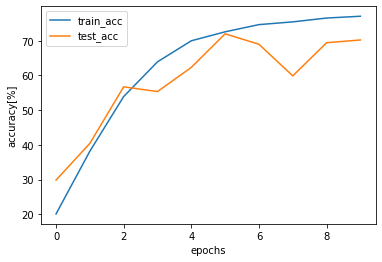

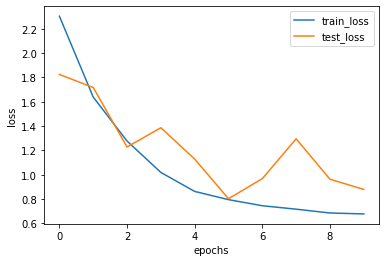

10/08 11:54:19 AM epoch 11
10/08 11:54:19 AM train 000 5.198493e-01 82.812500 100.000000
10/08 11:54:24 AM train 100 6.478297e-01 77.707302 98.360149
10/08 11:54:29 AM train 200 6.508796e-01 77.681903 98.414179
10/08 11:54:33 AM train 300 6.521054e-01 77.605897 98.510174
10/08 11:54:38 AM train 400 6.472769e-01 77.739246 98.597257
10/08 11:54:43 AM train 500 6.493552e-01 77.763224 98.521707
10/08 11:54:48 AM train 600 6.510539e-01 77.667429 98.554493
10/08 11:54:52 AM train 700 6.473306e-01 77.815175 98.593527
10/08 11:54:56 AM train_acc 77.860000
10/08 11:54:56 AM valid 000 1.371409e+00 60.937500 89.062500
10/08 11:54:58 AM valid 100 1.308798e+00 62.840347 93.564356
10/08 11:55:00 AM valid_acc 62.990000
10/08 11:55:00 AM epoch 12
10/08 11:55:00 AM train 000 4.785167e-01 84.375000 100.000000
10/08 11:55:05 AM train 100 6.412064e-01 77.939356 98.344678
10/08 11:55:10 AM train 200 6.438760e-01 78.062811 98.499689
10/08 11:55:15 AM train 300 6.400093e-01 78.265158 98.562085
10/08 11:55:20

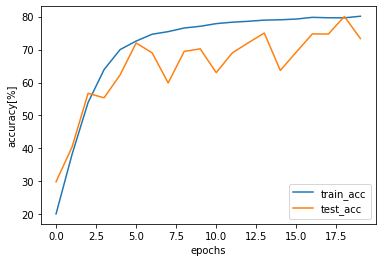

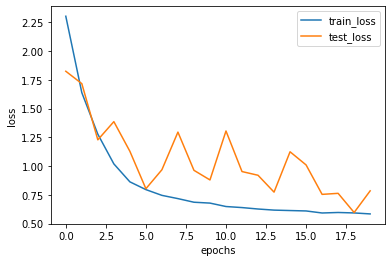

10/08 12:01:17 PM epoch 21
10/08 12:01:17 PM train 000 6.540987e-01 76.562500 98.437500
10/08 12:01:22 PM train 100 5.765087e-01 80.925124 98.839728
10/08 12:01:27 PM train 200 5.699067e-01 80.907960 98.958333
10/08 12:01:31 PM train 300 5.755956e-01 80.658223 98.894311
10/08 12:01:36 PM train 400 5.771022e-01 80.560318 98.862219
10/08 12:01:41 PM train 500 5.784820e-01 80.523328 98.880364
10/08 12:01:46 PM train 600 5.805029e-01 80.368656 98.856073
10/08 12:01:51 PM train 700 5.793212e-01 80.389622 98.867689
10/08 12:01:54 PM train_acc 80.398000
10/08 12:01:54 PM valid 000 9.349716e-01 70.312500 96.875000
10/08 12:01:56 PM valid 100 6.910256e-01 76.144802 98.375619
10/08 12:01:58 PM valid_acc 76.370000
10/08 12:01:58 PM epoch 22
10/08 12:01:59 PM train 000 6.673358e-01 76.562500 100.000000
10/08 12:02:03 PM train 100 5.740717e-01 80.275371 98.777847
10/08 12:02:08 PM train 200 5.726266e-01 80.068408 98.958333
10/08 12:02:13 PM train 300 5.792033e-01 80.248131 98.909884
10/08 12:02:18 

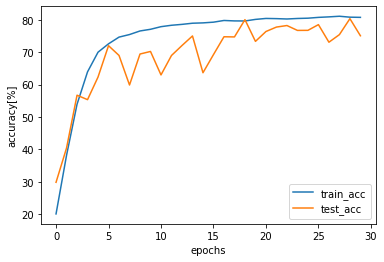

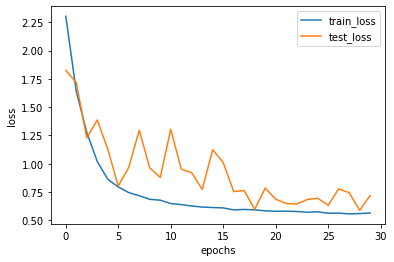

10/08 12:08:13 PM epoch 31
10/08 12:08:13 PM train 000 6.587057e-01 84.375000 98.437500
10/08 12:08:18 PM train 100 5.480235e-01 81.466584 98.978960
10/08 12:08:23 PM train 200 5.464315e-01 81.428794 98.849502
10/08 12:08:28 PM train 300 5.515672e-01 81.312292 98.826827
10/08 12:08:33 PM train 400 5.577181e-01 81.117519 98.815461
10/08 12:08:37 PM train 500 5.574867e-01 81.131487 98.827345
10/08 12:08:42 PM train 600 5.575164e-01 81.075811 98.822275
10/08 12:08:47 PM train 700 5.547715e-01 81.136323 98.852086
10/08 12:08:51 PM train_acc 81.184000
10/08 12:08:51 PM valid 000 5.648873e-01 78.125000 96.875000
10/08 12:08:53 PM valid 100 6.891666e-01 77.660891 98.329208
10/08 12:08:54 PM valid_acc 77.420000
10/08 12:08:55 PM epoch 32
10/08 12:08:55 PM train 000 3.425948e-01 85.937500 100.000000
10/08 12:09:00 PM train 100 5.390974e-01 81.358292 99.056312
10/08 12:09:04 PM train 200 5.489000e-01 81.187811 98.849502
10/08 12:09:09 PM train 300 5.415319e-01 81.410922 98.842400
10/08 12:09:14 

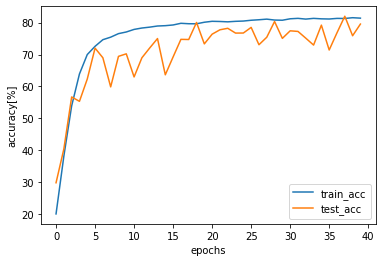

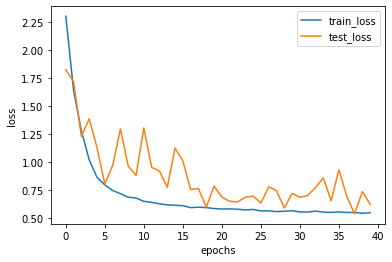

10/08 12:15:10 PM epoch 41
10/08 12:15:10 PM train 000 6.921526e-01 75.000000 100.000000
10/08 12:15:15 PM train 100 5.237653e-01 81.868812 99.164604
10/08 12:15:19 PM train 200 5.339589e-01 81.965174 99.121580
10/08 12:15:24 PM train 300 5.401160e-01 81.556271 99.081188
10/08 12:15:29 PM train 400 5.400928e-01 81.600686 99.049252
10/08 12:15:34 PM train 500 5.429562e-01 81.387226 99.061252
10/08 12:15:39 PM train 600 5.449297e-01 81.353993 99.058860
10/08 12:15:43 PM train 700 5.412630e-01 81.517475 99.059379
10/08 12:15:47 PM train_acc 81.454000
10/08 12:15:47 PM valid 000 8.295131e-01 70.312500 93.750000
10/08 12:15:49 PM valid 100 7.706949e-01 74.288366 98.623144
10/08 12:15:50 PM valid_acc 74.170000
10/08 12:15:51 PM epoch 42
10/08 12:15:51 PM train 000 5.235857e-01 79.687500 100.000000
10/08 12:15:56 PM train 100 5.207980e-01 82.193688 99.149134
10/08 12:16:01 PM train 200 5.242869e-01 82.105100 99.067164
10/08 12:16:05 PM train 300 5.328026e-01 81.919643 99.003322
10/08 12:16:10

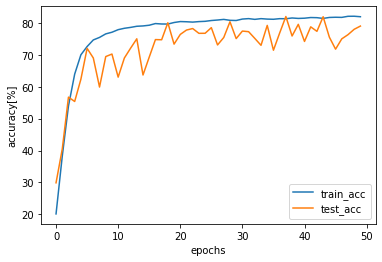

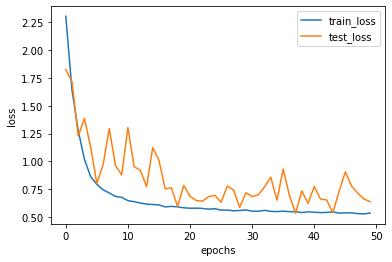

10/08 12:22:09 PM epoch 51
10/08 12:22:09 PM train 000 8.153388e-01 73.437500 95.312500
10/08 12:22:14 PM train 100 4.109016e-01 85.937500 99.241955
10/08 12:22:19 PM train 200 3.670385e-01 87.422264 99.448072
10/08 12:22:24 PM train 300 3.470715e-01 88.180025 99.522425
10/08 12:22:28 PM train 400 3.346531e-01 88.633884 99.579177
10/08 12:22:33 PM train 500 3.242712e-01 88.997006 99.582086
10/08 12:22:38 PM train 600 3.192864e-01 89.223690 99.586626
10/08 12:22:43 PM train 700 3.150816e-01 89.356723 99.587643
10/08 12:22:47 PM train_acc 89.444000
10/08 12:22:47 PM valid 000 3.270742e-01 89.062500 98.437500
10/08 12:22:49 PM valid 100 3.016866e-01 89.928837 99.582302
10/08 12:22:50 PM valid_acc 90.000000
10/08 12:22:51 PM epoch 52
10/08 12:22:51 PM train 000 3.211493e-01 89.062500 98.437500
10/08 12:22:56 PM train 100 2.621318e-01 90.903465 99.690594
10/08 12:23:00 PM train 200 2.599243e-01 91.021455 99.720149
10/08 12:23:05 PM train 300 2.614403e-01 91.055855 99.740449
10/08 12:23:10 P

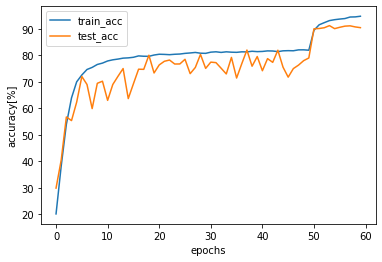

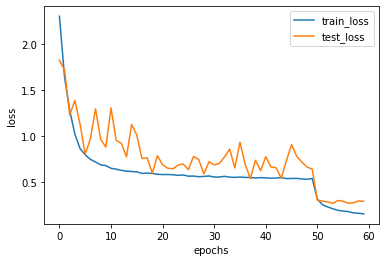

10/08 12:29:07 PM epoch 61
10/08 12:29:07 PM train 000 1.837218e-01 92.187500 100.000000
10/08 12:29:12 PM train 100 1.396998e-01 95.142327 99.922649
10/08 12:29:17 PM train 200 1.409097e-01 95.118159 99.945585
10/08 12:29:21 PM train 300 1.435179e-01 95.042566 99.937708
10/08 12:29:26 PM train 400 1.479325e-01 94.915056 99.918173
10/08 12:29:31 PM train 500 1.480589e-01 94.928892 99.918912
10/08 12:29:36 PM train 600 1.497753e-01 94.909526 99.903806
10/08 12:29:41 PM train 700 1.503337e-01 94.900143 99.906384
10/08 12:29:44 PM train_acc 94.836000
10/08 12:29:45 PM valid 000 2.841038e-01 87.500000 100.000000
10/08 12:29:47 PM valid 100 3.002425e-01 90.331064 99.767946
10/08 12:29:48 PM valid_acc 90.270000
10/08 12:29:49 PM epoch 62
10/08 12:29:49 PM train 000 5.991327e-02 98.437500 100.000000
10/08 12:29:53 PM train 100 1.360103e-01 95.250619 99.953589
10/08 12:29:58 PM train 200 1.374583e-01 95.164801 99.961132
10/08 12:30:03 PM train 300 1.406055e-01 95.115241 99.953281
10/08 12:30:0

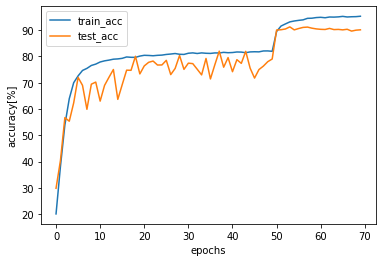

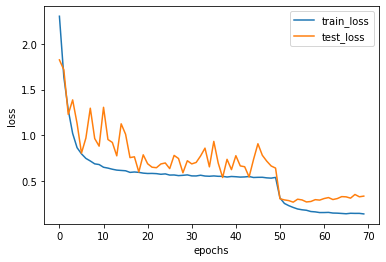

10/08 12:36:08 PM epoch 71
10/08 12:36:08 PM train 000 9.890357e-02 96.875000 100.000000
10/08 12:36:13 PM train 100 1.296287e-01 95.513614 99.907178
10/08 12:36:17 PM train 200 1.262396e-01 95.638993 99.898943
10/08 12:36:22 PM train 300 1.241941e-01 95.665490 99.932517
10/08 12:36:27 PM train 400 1.261904e-01 95.632014 99.933759
10/08 12:36:32 PM train 500 1.304558e-01 95.449726 99.940744
10/08 12:36:36 PM train 600 1.323868e-01 95.400894 99.942804
10/08 12:36:41 PM train 700 1.346145e-01 95.361537 99.946505
10/08 12:36:45 PM train_acc 95.288000
10/08 12:36:45 PM valid 000 3.357626e-01 90.625000 100.000000
10/08 12:36:47 PM valid 100 3.747067e-01 89.248144 99.628713
10/08 12:36:48 PM valid_acc 89.060000
10/08 12:36:49 PM epoch 72
10/08 12:36:49 PM train 000 1.186482e-01 96.875000 100.000000
10/08 12:36:54 PM train 100 1.497101e-01 95.034035 99.969059
10/08 12:36:59 PM train 200 1.417039e-01 95.226990 99.945585
10/08 12:37:03 PM train 300 1.444122e-01 95.063331 99.948090
10/08 12:37:0

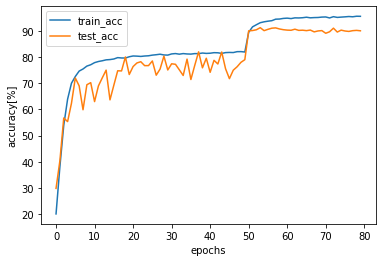

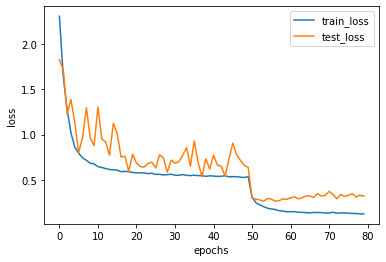

10/08 12:43:08 PM epoch 81
10/08 12:43:08 PM train 000 1.639166e-01 95.312500 100.000000
10/08 12:43:13 PM train 100 1.131173e-01 95.946782 99.969059
10/08 12:43:18 PM train 200 1.231845e-01 95.693408 99.976679
10/08 12:43:22 PM train 300 1.234424e-01 95.831603 99.968854
10/08 12:43:27 PM train 400 1.283308e-01 95.612531 99.961035
10/08 12:43:32 PM train 500 1.275107e-01 95.639970 99.968812
10/08 12:43:37 PM train 600 1.294680e-01 95.567284 99.968802
10/08 12:43:41 PM train 700 1.301001e-01 95.544312 99.964337
10/08 12:43:45 PM train_acc 95.472000
10/08 12:43:45 PM valid 000 2.493968e-01 90.625000 100.000000
10/08 12:43:48 PM valid 100 3.342241e-01 90.284653 99.427599
10/08 12:43:49 PM valid_acc 90.150000
10/08 12:43:50 PM epoch 82
10/08 12:43:50 PM train 000 6.200771e-02 96.875000 100.000000
10/08 12:43:55 PM train 100 1.215810e-01 95.776609 99.984530
10/08 12:43:59 PM train 200 1.150035e-01 96.074316 99.968905
10/08 12:44:04 PM train 300 1.195371e-01 95.873131 99.953281
10/08 12:44:0

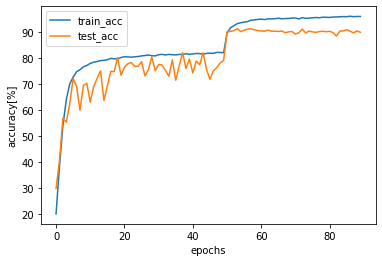

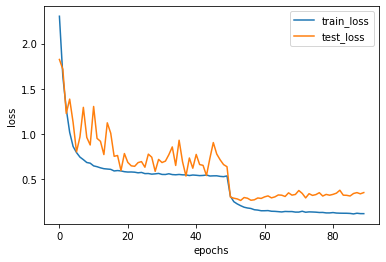

10/08 12:50:10 PM epoch 91
10/08 12:50:10 PM train 000 1.330136e-01 90.625000 100.000000
10/08 12:50:14 PM train 100 1.025433e-01 96.194307 99.984530
10/08 12:50:19 PM train 200 1.063923e-01 96.245336 99.984453
10/08 12:50:24 PM train 300 1.068595e-01 96.194975 99.979236
10/08 12:50:29 PM train 400 1.109230e-01 96.056733 99.968828
10/08 12:50:34 PM train 500 1.120204e-01 96.045409 99.971931
10/08 12:50:38 PM train 600 1.154412e-01 95.915661 99.968802
10/08 12:50:43 PM train 700 1.195141e-01 95.753834 99.971024
10/08 12:50:47 PM train_acc 95.766000
10/08 12:50:47 PM valid 000 3.319929e-01 90.625000 100.000000
10/08 12:50:49 PM valid 100 3.046089e-01 91.042698 99.706064
10/08 12:50:50 PM valid_acc 91.040000
10/08 12:50:51 PM epoch 92
10/08 12:50:51 PM train 000 7.574751e-02 95.312500 100.000000
10/08 12:50:56 PM train 100 1.030545e-01 96.410891 99.984530
10/08 12:51:01 PM train 200 1.062943e-01 96.330846 99.992226
10/08 12:51:05 PM train 300 1.098695e-01 96.236503 99.979236
10/08 12:51:1

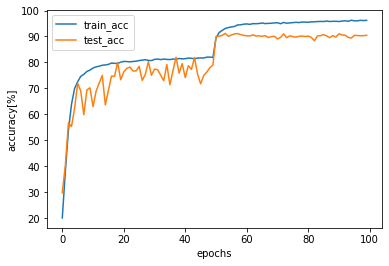

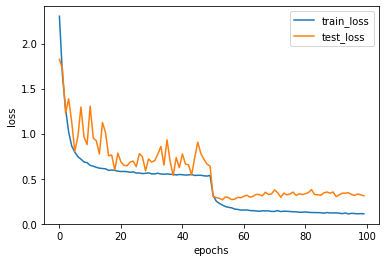

10/08 12:57:10 PM epoch 101
10/08 12:57:11 PM train 000 1.153874e-01 96.875000 100.000000
10/08 12:57:15 PM train 100 9.910105e-02 96.751238 99.984530
10/08 12:57:20 PM train 200 1.026131e-01 96.564055 99.984453
10/08 12:57:25 PM train 300 1.044626e-01 96.418189 99.979236
10/08 12:57:30 PM train 400 1.033225e-01 96.446384 99.976621
10/08 12:57:34 PM train 500 1.028378e-01 96.472680 99.978169
10/08 12:57:39 PM train 600 1.042006e-01 96.373232 99.976601
10/08 12:57:44 PM train 700 1.071939e-01 96.282097 99.973252
10/08 12:57:48 PM train_acc 96.218000
10/08 12:57:48 PM valid 000 3.359997e-01 90.625000 100.000000
10/08 12:57:50 PM valid 100 3.308712e-01 90.594059 99.504950
10/08 12:57:51 PM valid_acc 90.690000
10/08 12:57:52 PM epoch 102
10/08 12:57:52 PM train 000 1.167013e-01 92.187500 100.000000
10/08 12:57:57 PM train 100 9.417619e-02 96.704827 100.000000
10/08 12:58:02 PM train 200 9.095986e-02 96.867226 99.992226
10/08 12:58:07 PM train 300 9.860843e-02 96.631022 99.994809
10/08 12:5

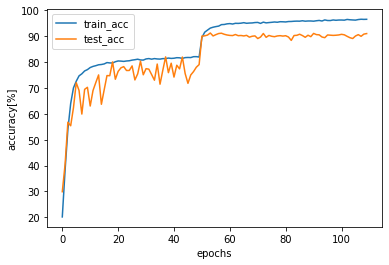

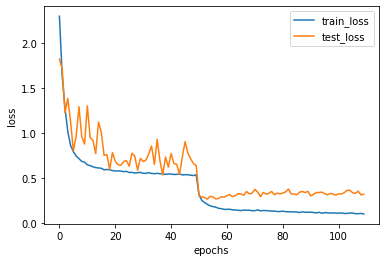

10/08 01:04:12 PM epoch 111
10/08 01:04:12 PM train 000 8.399789e-02 96.875000 100.000000
10/08 01:04:17 PM train 100 8.380096e-02 97.230817 100.000000
10/08 01:04:22 PM train 200 8.772256e-02 97.069341 99.992226
10/08 01:04:27 PM train 300 9.168023e-02 96.947674 99.984427
10/08 01:04:32 PM train 400 9.299415e-02 96.824345 99.980517
10/08 01:04:36 PM train 500 9.663015e-02 96.697231 99.981287
10/08 01:04:41 PM train 600 9.939435e-02 96.542221 99.976601
10/08 01:04:46 PM train 700 1.012836e-01 96.525053 99.977710
10/08 01:04:50 PM train_acc 96.474000
10/08 01:04:50 PM valid 000 3.460566e-01 89.062500 100.000000
10/08 01:04:52 PM valid 100 3.443888e-01 90.547649 99.458540
10/08 01:04:53 PM valid_acc 90.200000
10/08 01:04:54 PM epoch 112
10/08 01:04:54 PM train 000 7.859209e-02 96.875000 100.000000
10/08 01:04:59 PM train 100 9.141131e-02 97.014233 100.000000
10/08 01:05:04 PM train 200 9.430672e-02 96.828358 100.000000
10/08 01:05:08 PM train 300 9.526876e-02 96.724460 100.000000
10/08 0

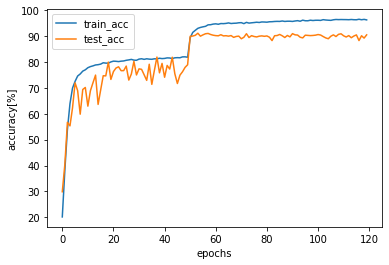

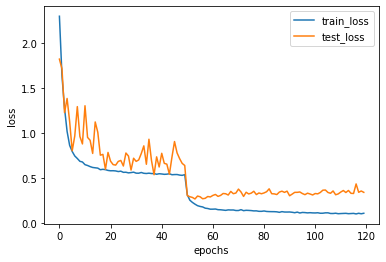

10/08 01:11:16 PM epoch 121
10/08 01:11:16 PM train 000 1.545819e-01 93.750000 100.000000
10/08 01:11:21 PM train 100 9.450180e-02 96.627475 99.984530
10/08 01:11:25 PM train 200 8.715293e-02 97.069341 99.984453
10/08 01:11:30 PM train 300 9.037320e-02 96.952865 99.984427
10/08 01:11:35 PM train 400 9.549139e-02 96.738622 99.976621
10/08 01:11:40 PM train 500 9.748461e-02 96.597430 99.978169
10/08 01:11:45 PM train 600 9.747409e-02 96.599418 99.976601
10/08 01:11:49 PM train 700 9.946972e-02 96.527282 99.977710
10/08 01:11:53 PM train_acc 96.524000
10/08 01:11:54 PM valid 000 3.670401e-01 85.937500 100.000000
10/08 01:11:56 PM valid 100 3.545244e-01 89.665842 99.613243
10/08 01:11:57 PM valid_acc 89.390000
10/08 01:11:58 PM epoch 122
10/08 01:11:58 PM train 000 8.069653e-02 96.875000 100.000000
10/08 01:12:03 PM train 100 1.186987e-01 96.178837 99.969059
10/08 01:12:07 PM train 200 1.115460e-01 96.276430 99.984453
10/08 01:12:12 PM train 300 1.034843e-01 96.475291 99.984427
10/08 01:12

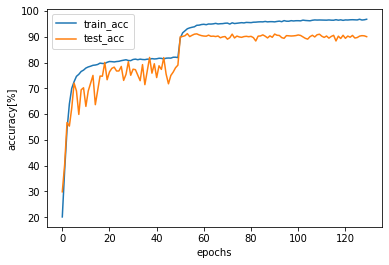

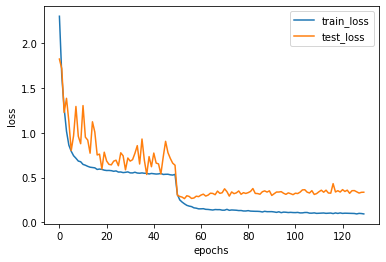

10/08 01:18:22 PM epoch 131
10/08 01:18:22 PM train 000 1.935105e-02 100.000000 100.000000
10/08 01:18:27 PM train 100 9.257565e-02 96.936881 99.984530
10/08 01:18:31 PM train 200 8.374398e-02 97.201493 99.992226
10/08 01:18:36 PM train 300 8.791621e-02 97.056686 99.984427
10/08 01:18:41 PM train 400 8.861632e-02 97.046446 99.984414
10/08 01:18:46 PM train 500 9.171668e-02 96.918663 99.987525
10/08 01:18:51 PM train 600 9.420062e-02 96.828203 99.987001
10/08 01:18:55 PM train 700 9.517663e-02 96.752407 99.986626
10/08 01:18:59 PM train_acc 96.660000
10/08 01:18:59 PM valid 000 2.746248e-01 90.625000 100.000000
10/08 01:19:01 PM valid 100 3.457248e-01 90.021658 99.675124
10/08 01:19:03 PM valid_acc 89.860000
10/08 01:19:03 PM epoch 132
10/08 01:19:04 PM train 000 6.680423e-02 96.875000 100.000000
10/08 01:19:08 PM train 100 9.871654e-02 96.782178 100.000000
10/08 01:19:13 PM train 200 9.646516e-02 96.672886 99.984453
10/08 01:19:18 PM train 300 9.604076e-02 96.714078 99.989618
10/08 01:

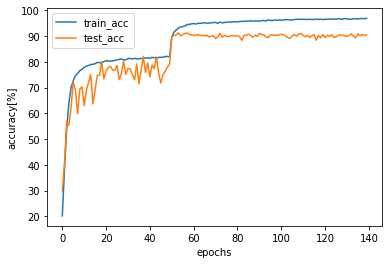

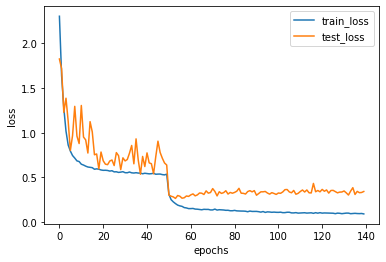

10/08 01:25:27 PM epoch 141
10/08 01:25:27 PM train 000 4.275000e-02 98.437500 100.000000
10/08 01:25:32 PM train 100 8.026438e-02 97.014233 99.984530
10/08 01:25:36 PM train 200 8.533357e-02 96.937189 99.984453
10/08 01:25:41 PM train 300 8.680792e-02 97.009967 99.963663
10/08 01:25:46 PM train 400 9.091189e-02 96.785380 99.972724
10/08 01:25:51 PM train 500 9.204621e-02 96.781437 99.978169
10/08 01:25:56 PM train 600 9.138092e-02 96.797005 99.981801
10/08 01:26:00 PM train 700 9.409970e-02 96.701141 99.982168
10/08 01:26:04 PM train_acc 96.672000
10/08 01:26:04 PM valid 000 3.426766e-01 92.187500 100.000000
10/08 01:26:06 PM valid 100 3.349121e-01 90.408416 99.535891
10/08 01:26:08 PM valid_acc 90.340000
10/08 01:26:08 PM epoch 142
10/08 01:26:08 PM train 000 6.796324e-02 96.875000 100.000000
10/08 01:26:13 PM train 100 8.253715e-02 96.967822 100.000000
10/08 01:26:18 PM train 200 8.620789e-02 96.952736 99.984453
10/08 01:26:23 PM train 300 8.990737e-02 96.869809 99.984427
10/08 01:2

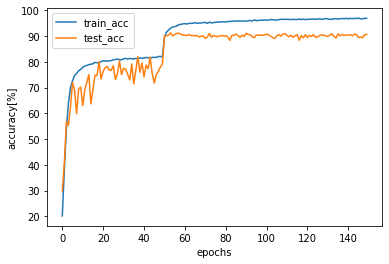

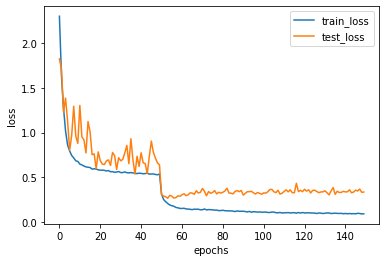

10/08 01:32:35 PM epoch 151
10/08 01:32:35 PM train 000 4.265357e-02 100.000000 100.000000
10/08 01:32:40 PM train 100 5.706053e-02 98.282797 99.984530
10/08 01:32:44 PM train 200 5.297738e-02 98.313122 99.992226
10/08 01:32:49 PM train 300 4.803609e-02 98.484219 99.994809
10/08 01:32:54 PM train 400 4.514129e-02 98.589464 99.996103
10/08 01:32:59 PM train 500 4.304935e-02 98.652695 99.993762
10/08 01:33:03 PM train 600 4.109594e-02 98.731281 99.994800
10/08 01:33:08 PM train 700 3.976392e-02 98.778531 99.995542
10/08 01:33:12 PM train_acc 98.848000
10/08 01:33:12 PM valid 000 2.118423e-01 90.625000 100.000000
10/08 01:33:14 PM valid 100 2.437462e-01 93.131188 99.721535
10/08 01:33:16 PM valid_acc 93.070000
10/08 01:33:16 PM epoch 152
10/08 01:33:16 PM train 000 6.339201e-02 96.875000 100.000000
10/08 01:33:21 PM train 100 2.767231e-02 99.257426 100.000000
10/08 01:33:26 PM train 200 2.805332e-02 99.230410 100.000000
10/08 01:33:31 PM train 300 2.741235e-02 99.278447 100.000000
10/08 0

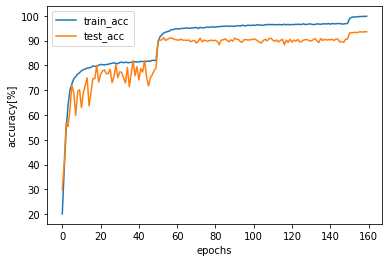

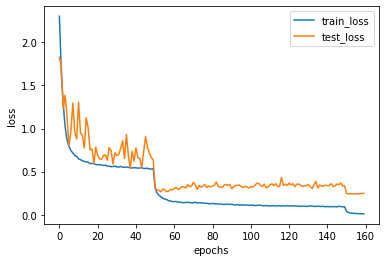

10/08 01:39:39 PM epoch 161
10/08 01:39:39 PM train 000 7.129448e-03 100.000000 100.000000
10/08 01:39:44 PM train 100 8.580560e-03 99.845297 100.000000
10/08 01:39:48 PM train 200 8.518079e-03 99.828980 100.000000
10/08 01:39:53 PM train 300 8.813961e-03 99.807932 100.000000
10/08 01:39:58 PM train 400 8.698739e-03 99.816864 100.000000
10/08 01:40:03 PM train 500 8.659306e-03 99.819112 100.000000
10/08 01:40:07 PM train 600 8.516347e-03 99.820611 100.000000
10/08 01:40:12 PM train 700 8.419190e-03 99.826141 100.000000
10/08 01:40:16 PM train_acc 99.822000
10/08 01:40:16 PM valid 000 1.838869e-01 93.750000 100.000000
10/08 01:40:18 PM valid 100 2.446564e-01 93.858292 99.644183
10/08 01:40:19 PM valid_acc 93.590000
10/08 01:40:20 PM epoch 162
10/08 01:40:20 PM train 000 1.248401e-02 100.000000 100.000000
10/08 01:40:25 PM train 100 6.167280e-03 99.938119 100.000000
10/08 01:40:30 PM train 200 7.692205e-03 99.875622 100.000000
10/08 01:40:34 PM train 300 8.055437e-03 99.849460 100.000000

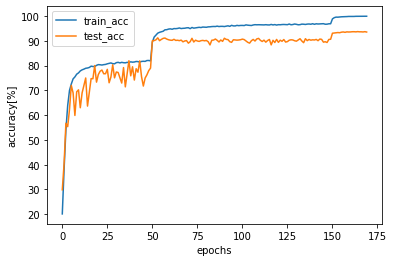

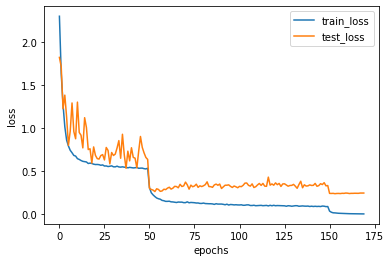

10/08 01:46:42 PM epoch 171
10/08 01:46:42 PM train 000 4.953444e-03 100.000000 100.000000
10/08 01:46:47 PM train 100 4.269104e-03 99.984530 100.000000
10/08 01:46:52 PM train 200 4.156650e-03 99.961132 100.000000
10/08 01:46:57 PM train 300 4.767968e-03 99.948090 100.000000
10/08 01:47:02 PM train 400 4.664455e-03 99.953242 100.000000
10/08 01:47:06 PM train 500 4.749581e-03 99.950100 100.000000
10/08 01:47:11 PM train 600 4.758484e-03 99.945403 100.000000
10/08 01:47:16 PM train 700 4.705641e-03 99.942047 100.000000
10/08 01:47:20 PM train_acc 99.938000
10/08 01:47:20 PM valid 000 1.657338e-01 93.750000 100.000000
10/08 01:47:22 PM valid 100 2.483389e-01 93.873762 99.690594
10/08 01:47:23 PM valid_acc 93.660000
10/08 01:47:24 PM epoch 172
10/08 01:47:24 PM train 000 1.341570e-02 100.000000 100.000000
10/08 01:47:29 PM train 100 4.673301e-03 99.969059 100.000000
10/08 01:47:34 PM train 200 4.465330e-03 99.953358 100.000000
10/08 01:47:39 PM train 300 4.771593e-03 99.942899 100.000000

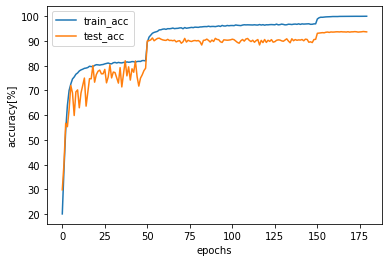

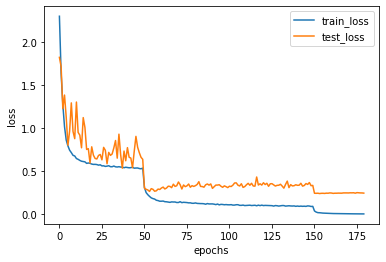

10/08 01:53:47 PM epoch 181
10/08 01:53:48 PM train 000 1.007024e-02 100.000000 100.000000
10/08 01:53:52 PM train 100 5.257222e-03 99.922649 100.000000
10/08 01:53:57 PM train 200 4.708260e-03 99.930037 100.000000
10/08 01:54:02 PM train 300 4.427535e-03 99.927326 100.000000
10/08 01:54:07 PM train 400 4.107208e-03 99.937656 100.000000
10/08 01:54:11 PM train 500 3.888463e-03 99.946981 100.000000
10/08 01:54:16 PM train 600 3.848400e-03 99.945403 100.000000
10/08 01:54:21 PM train 700 3.825228e-03 99.950963 100.000000
10/08 01:54:25 PM train_acc 99.952000
10/08 01:54:25 PM valid 000 1.648380e-01 95.312500 100.000000
10/08 01:54:27 PM valid 100 2.462312e-01 93.951114 99.721535
10/08 01:54:28 PM valid_acc 93.790000
10/08 01:54:29 PM epoch 182
10/08 01:54:29 PM train 000 2.202622e-03 100.000000 100.000000
10/08 01:54:34 PM train 100 3.982739e-03 99.938119 100.000000
10/08 01:54:39 PM train 200 3.954512e-03 99.930037 100.000000
10/08 01:54:44 PM train 300 3.936135e-03 99.948090 100.000000

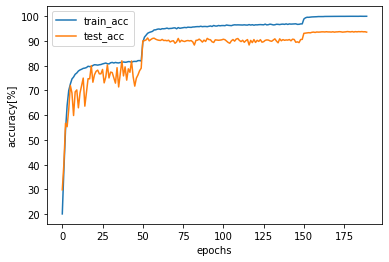

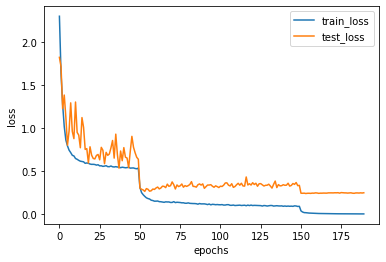

10/08 02:00:54 PM epoch 191
10/08 02:00:54 PM train 000 3.159088e-03 100.000000 100.000000
10/08 02:00:59 PM train 100 2.803487e-03 99.969059 100.000000
10/08 02:01:03 PM train 200 3.018322e-03 99.953358 100.000000
10/08 02:01:08 PM train 300 3.131117e-03 99.953281 100.000000
10/08 02:01:13 PM train 400 3.248432e-03 99.953242 100.000000
10/08 02:01:18 PM train 500 3.227353e-03 99.959456 100.000000
10/08 02:01:22 PM train 600 3.186801e-03 99.958403 100.000000
10/08 02:01:27 PM train 700 3.187790e-03 99.962108 100.000000
10/08 02:01:31 PM train_acc 99.962000
10/08 02:01:31 PM valid 000 2.006893e-01 95.312500 100.000000
10/08 02:01:33 PM valid 100 2.493964e-01 93.734530 99.721535
10/08 02:01:34 PM valid_acc 93.650000
10/08 02:01:35 PM epoch 192
10/08 02:01:35 PM train 000 9.605802e-04 100.000000 100.000000
10/08 02:01:40 PM train 100 3.014888e-03 99.953589 100.000000
10/08 02:01:45 PM train 200 2.739677e-03 99.976679 100.000000
10/08 02:01:50 PM train 300 3.179696e-03 99.963663 100.000000

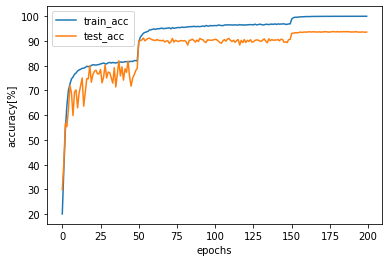

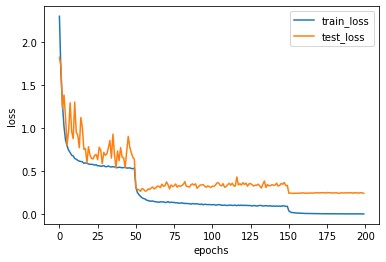

10/08 02:08:01 PM epoch 201
10/08 02:08:01 PM train 000 2.119825e-03 100.000000 100.000000
10/08 02:08:06 PM train 100 2.887146e-03 99.984530 100.000000
10/08 02:08:11 PM train 200 2.550562e-03 99.992226 100.000000
10/08 02:08:16 PM train 300 2.658137e-03 99.989618 100.000000
10/08 02:08:21 PM train 400 2.642413e-03 99.988310 100.000000
10/08 02:08:26 PM train 500 2.804352e-03 99.981287 100.000000
10/08 02:08:31 PM train 600 2.727250e-03 99.981801 100.000000
10/08 02:08:36 PM train 700 2.724669e-03 99.979939 100.000000
10/08 02:08:40 PM train_acc 99.982000
10/08 02:08:40 PM valid 000 1.894727e-01 93.750000 100.000000
10/08 02:08:42 PM valid 100 2.478858e-01 93.641708 99.659653
10/08 02:08:43 PM valid_acc 93.550000
10/08 02:08:44 PM epoch 202
10/08 02:08:44 PM train 000 4.977761e-03 100.000000 100.000000
10/08 02:08:49 PM train 100 3.014326e-03 99.953589 100.000000
10/08 02:08:54 PM train 200 3.051867e-03 99.953358 100.000000
10/08 02:08:59 PM train 300 2.886480e-03 99.958472 100.000000

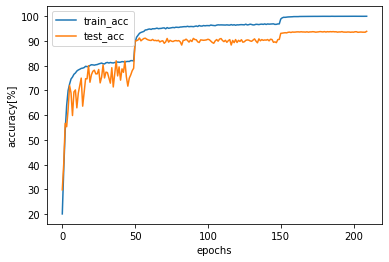

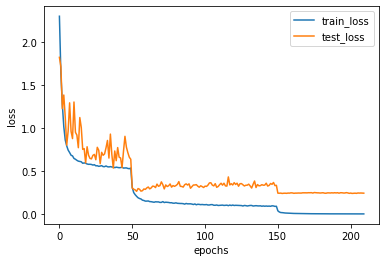

10/08 02:15:11 PM epoch 211
10/08 02:15:11 PM train 000 4.359502e-03 100.000000 100.000000
10/08 02:15:16 PM train 100 2.686031e-03 99.984530 100.000000
10/08 02:15:21 PM train 200 2.604501e-03 99.984453 100.000000
10/08 02:15:25 PM train 300 2.493783e-03 99.984427 100.000000
10/08 02:15:30 PM train 400 2.394815e-03 99.988310 100.000000
10/08 02:15:35 PM train 500 2.275913e-03 99.990644 100.000000
10/08 02:15:40 PM train 600 2.299588e-03 99.992200 100.000000
10/08 02:15:45 PM train 700 2.282251e-03 99.991084 100.000000
10/08 02:15:48 PM train_acc 99.992000
10/08 02:15:49 PM valid 000 1.658670e-01 92.187500 100.000000
10/08 02:15:51 PM valid 100 2.421043e-01 93.904703 99.752475
10/08 02:15:52 PM valid_acc 93.820000
10/08 02:15:53 PM epoch 212
10/08 02:15:53 PM train 000 1.773186e-03 100.000000 100.000000
10/08 02:15:58 PM train 100 1.792913e-03 100.000000 100.000000
10/08 02:16:02 PM train 200 2.169703e-03 99.984453 100.000000
10/08 02:16:07 PM train 300 2.172464e-03 99.989618 100.00000

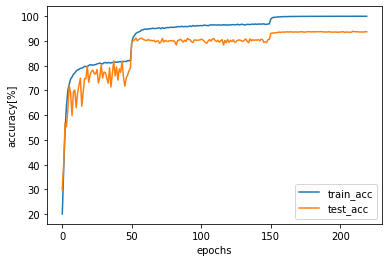

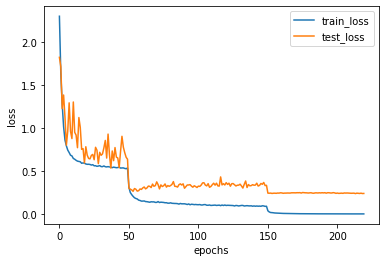

10/08 02:22:19 PM epoch 221
10/08 02:22:19 PM train 000 2.499874e-03 100.000000 100.000000
10/08 02:22:24 PM train 100 2.066037e-03 99.984530 100.000000
10/08 02:22:29 PM train 200 2.019527e-03 99.992226 100.000000
10/08 02:22:34 PM train 300 2.014479e-03 99.984427 100.000000
10/08 02:22:39 PM train 400 2.008704e-03 99.988310 100.000000
10/08 02:22:43 PM train 500 2.038977e-03 99.984406 100.000000
10/08 02:22:48 PM train 600 2.279027e-03 99.979201 100.000000
10/08 02:22:53 PM train 700 2.287834e-03 99.979939 100.000000
10/08 02:22:57 PM train_acc 99.982000
10/08 02:22:57 PM valid 000 1.884409e-01 93.750000 100.000000
10/08 02:22:59 PM valid 100 2.445427e-01 93.626238 99.706064
10/08 02:23:00 PM valid_acc 93.570000
10/08 02:23:01 PM epoch 222
10/08 02:23:01 PM train 000 4.370593e-03 100.000000 100.000000
10/08 02:23:06 PM train 100 2.153864e-03 100.000000 100.000000
10/08 02:23:11 PM train 200 2.266338e-03 99.984453 100.000000
10/08 02:23:15 PM train 300 2.202230e-03 99.989618 100.00000

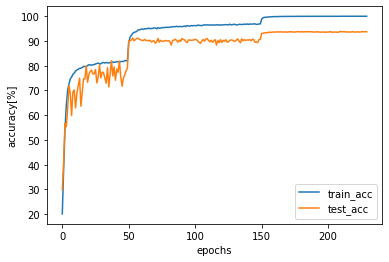

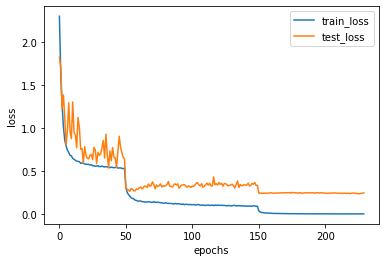

10/08 02:29:27 PM epoch 231
10/08 02:29:27 PM train 000 1.020280e-03 100.000000 100.000000
10/08 02:29:32 PM train 100 2.153703e-03 99.984530 100.000000
10/08 02:29:36 PM train 200 2.064686e-03 99.992226 100.000000
10/08 02:29:41 PM train 300 2.085446e-03 99.984427 100.000000
10/08 02:29:46 PM train 400 2.194563e-03 99.984414 100.000000
10/08 02:29:51 PM train 500 2.189037e-03 99.987525 100.000000
10/08 02:29:55 PM train 600 2.161526e-03 99.989601 100.000000
10/08 02:30:00 PM train 700 2.147544e-03 99.988855 100.000000
10/08 02:30:04 PM train_acc 99.990000
10/08 02:30:04 PM valid 000 1.377862e-01 93.750000 100.000000
10/08 02:30:06 PM valid 100 2.444734e-01 93.904703 99.783416
10/08 02:30:07 PM valid_acc 93.850000
10/08 02:30:08 PM epoch 232
10/08 02:30:08 PM train 000 3.849573e-03 100.000000 100.000000
10/08 02:30:13 PM train 100 1.968183e-03 100.000000 100.000000
10/08 02:30:18 PM train 200 1.917050e-03 100.000000 100.000000
10/08 02:30:22 PM train 300 1.969597e-03 100.000000 100.000

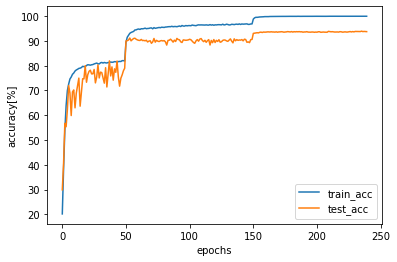

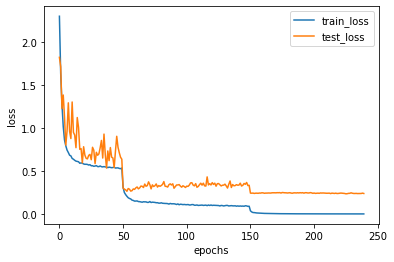

10/08 02:36:34 PM epoch 241
10/08 02:36:34 PM train 000 1.213143e-03 100.000000 100.000000
10/08 02:36:39 PM train 100 1.711907e-03 100.000000 100.000000
10/08 02:36:44 PM train 200 1.685466e-03 99.992226 100.000000
10/08 02:36:49 PM train 300 1.668514e-03 99.994809 100.000000
10/08 02:36:54 PM train 400 1.648067e-03 99.996103 100.000000
10/08 02:36:58 PM train 500 1.652141e-03 99.996881 100.000000
10/08 02:37:03 PM train 600 1.673252e-03 99.997400 100.000000
10/08 02:37:08 PM train 700 1.664611e-03 99.997771 100.000000
10/08 02:37:12 PM train_acc 99.996000
10/08 02:37:12 PM valid 000 1.447449e-01 95.312500 100.000000
10/08 02:37:14 PM valid 100 2.344290e-01 94.074876 99.752475
10/08 02:37:16 PM valid_acc 93.880000
10/08 02:37:16 PM epoch 242
10/08 02:37:17 PM train 000 9.189143e-04 100.000000 100.000000
10/08 02:37:21 PM train 100 1.806566e-03 100.000000 100.000000
10/08 02:37:26 PM train 200 1.954125e-03 99.992226 100.000000
10/08 02:37:31 PM train 300 1.933581e-03 99.994809 100.0000

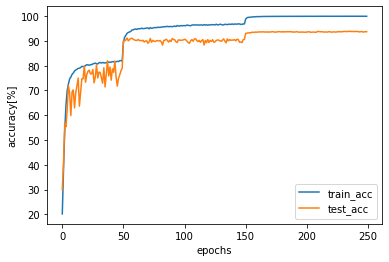

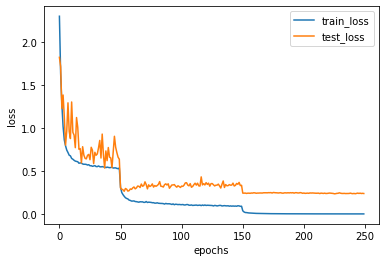

10/08 02:43:46 PM epoch 251
10/08 02:43:46 PM train 000 1.265378e-03 100.000000 100.000000
10/08 02:43:51 PM train 100 1.828788e-03 99.984530 100.000000
10/08 02:43:56 PM train 200 1.691877e-03 99.992226 100.000000
10/08 02:44:01 PM train 300 1.692605e-03 99.994809 100.000000
10/08 02:44:06 PM train 400 1.697112e-03 99.996103 100.000000
10/08 02:44:10 PM train 500 1.688758e-03 99.996881 100.000000
10/08 02:44:15 PM train 600 1.685881e-03 99.994800 100.000000
10/08 02:44:20 PM train 700 1.690470e-03 99.995542 100.000000
10/08 02:44:24 PM train_acc 99.994000
10/08 02:44:24 PM valid 000 1.593993e-01 93.750000 100.000000
10/08 02:44:26 PM valid 100 2.425926e-01 93.750000 99.721535
10/08 02:44:27 PM valid_acc 93.750000
10/08 02:44:28 PM epoch 252
10/08 02:44:28 PM train 000 1.472257e-03 100.000000 100.000000
10/08 02:44:33 PM train 100 1.870918e-03 99.969059 100.000000
10/08 02:44:37 PM train 200 1.778994e-03 99.984453 100.000000
10/08 02:44:42 PM train 300 1.797934e-03 99.989618 100.000000

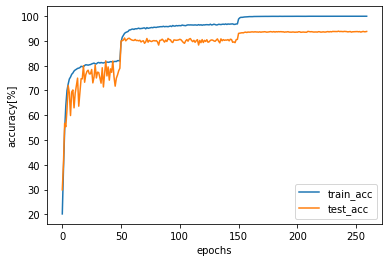

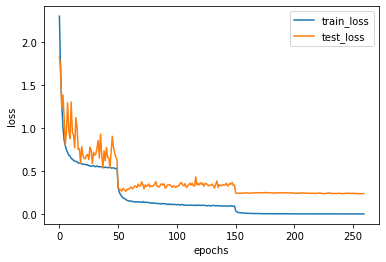

10/08 02:50:55 PM epoch 261
10/08 02:50:55 PM train 000 7.794918e-04 100.000000 100.000000
10/08 02:51:00 PM train 100 1.621636e-03 99.984530 100.000000
10/08 02:51:05 PM train 200 1.533005e-03 99.992226 100.000000
10/08 02:51:10 PM train 300 1.577897e-03 99.994809 100.000000
10/08 02:51:14 PM train 400 1.592197e-03 99.996103 100.000000
10/08 02:51:19 PM train 500 1.646056e-03 99.993762 100.000000
10/08 02:51:24 PM train 600 1.640531e-03 99.994800 100.000000
10/08 02:51:29 PM train 700 1.644321e-03 99.995542 100.000000
10/08 02:51:33 PM train_acc 99.996000
10/08 02:51:33 PM valid 000 1.443106e-01 93.750000 100.000000
10/08 02:51:35 PM valid 100 2.407541e-01 93.796411 99.721535
10/08 02:51:36 PM valid_acc 93.780000
10/08 02:51:37 PM epoch 262
10/08 02:51:37 PM train 000 4.557967e-03 100.000000 100.000000
10/08 02:51:42 PM train 100 1.776131e-03 100.000000 100.000000
10/08 02:51:46 PM train 200 1.616631e-03 100.000000 100.000000
10/08 02:51:51 PM train 300 1.652285e-03 100.000000 100.000

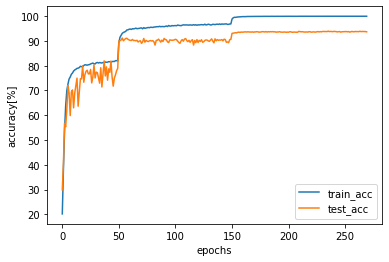

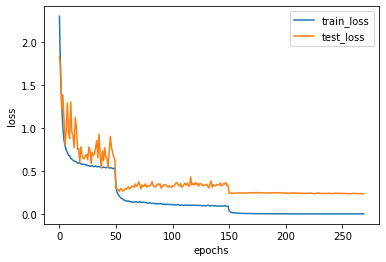

10/08 02:58:05 PM epoch 271
10/08 02:58:05 PM train 000 1.343327e-03 100.000000 100.000000
10/08 02:58:10 PM train 100 1.444237e-03 100.000000 100.000000
10/08 02:58:15 PM train 200 1.494101e-03 100.000000 100.000000
10/08 02:58:20 PM train 300 1.561019e-03 100.000000 100.000000
10/08 02:58:24 PM train 400 1.519605e-03 100.000000 100.000000
10/08 02:58:29 PM train 500 1.520696e-03 100.000000 100.000000
10/08 02:58:34 PM train 600 1.534738e-03 99.997400 100.000000
10/08 02:58:39 PM train 700 1.546237e-03 99.995542 100.000000
10/08 02:58:43 PM train_acc 99.994000
10/08 02:58:43 PM valid 000 1.322502e-01 93.750000 100.000000
10/08 02:58:45 PM valid 100 2.346141e-01 93.873762 99.737005
10/08 02:58:46 PM valid_acc 93.740000
10/08 02:58:47 PM epoch 272
10/08 02:58:47 PM train 000 8.741668e-04 100.000000 100.000000
10/08 02:58:52 PM train 100 1.668177e-03 100.000000 100.000000
10/08 02:58:56 PM train 200 1.633702e-03 100.000000 100.000000
10/08 02:59:01 PM train 300 1.693154e-03 100.000000 10

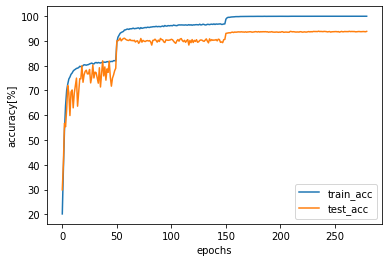

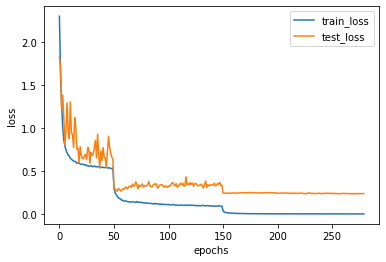

10/08 03:05:16 PM epoch 281
10/08 03:05:16 PM train 000 5.880247e-04 100.000000 100.000000
10/08 03:05:21 PM train 100 1.611165e-03 100.000000 100.000000
10/08 03:05:26 PM train 200 1.504078e-03 100.000000 100.000000
10/08 03:05:30 PM train 300 1.443176e-03 100.000000 100.000000
10/08 03:05:35 PM train 400 1.442613e-03 100.000000 100.000000
10/08 03:05:40 PM train 500 1.460908e-03 100.000000 100.000000
10/08 03:05:45 PM train 600 1.486767e-03 100.000000 100.000000
10/08 03:05:49 PM train 700 1.503600e-03 100.000000 100.000000
10/08 03:05:53 PM train_acc 100.000000
10/08 03:05:53 PM valid 000 1.363223e-01 93.750000 100.000000
10/08 03:05:55 PM valid 100 2.376567e-01 93.982054 99.690594
10/08 03:05:57 PM valid_acc 93.840000
10/08 03:05:57 PM epoch 282
10/08 03:05:57 PM train 000 1.077151e-03 100.000000 100.000000
10/08 03:06:02 PM train 100 1.291311e-03 100.000000 100.000000
10/08 03:06:07 PM train 200 1.419459e-03 100.000000 100.000000
10/08 03:06:12 PM train 300 1.549588e-03 99.994809 

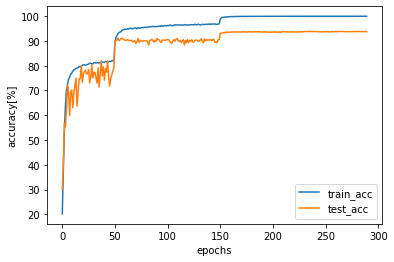

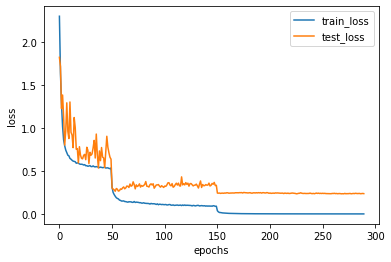

10/08 03:12:27 PM epoch 291
10/08 03:12:27 PM train 000 8.468330e-04 100.000000 100.000000
10/08 03:12:32 PM train 100 1.563616e-03 99.984530 100.000000
10/08 03:12:37 PM train 200 1.579642e-03 99.992226 100.000000
10/08 03:12:41 PM train 300 1.565924e-03 99.994809 100.000000
10/08 03:12:46 PM train 400 1.542028e-03 99.996103 100.000000
10/08 03:12:51 PM train 500 1.538446e-03 99.996881 100.000000
10/08 03:12:56 PM train 600 1.528133e-03 99.994800 100.000000
10/08 03:13:01 PM train 700 1.507730e-03 99.995542 100.000000
10/08 03:13:04 PM train_acc 99.994000
10/08 03:13:04 PM valid 000 1.368505e-01 93.750000 100.000000
10/08 03:13:07 PM valid 100 2.361832e-01 93.966584 99.737005
10/08 03:13:08 PM valid_acc 93.860000
10/08 03:13:09 PM epoch 292
10/08 03:13:09 PM train 000 4.919521e-04 100.000000 100.000000
10/08 03:13:14 PM train 100 1.525528e-03 99.984530 100.000000
10/08 03:13:19 PM train 200 1.456420e-03 99.992226 100.000000
10/08 03:13:24 PM train 300 1.484804e-03 99.994809 100.000000

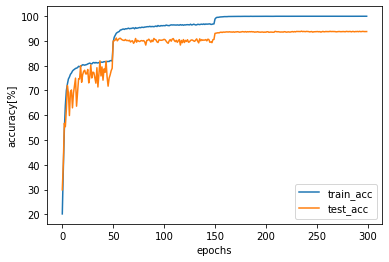

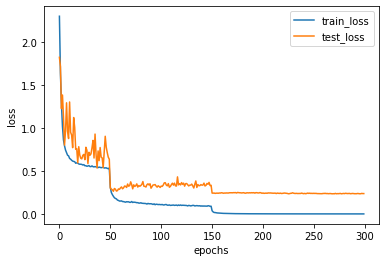

10/08 03:19:39 PM best acc 93.97


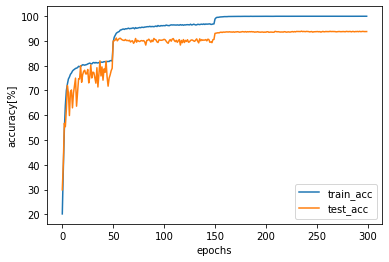

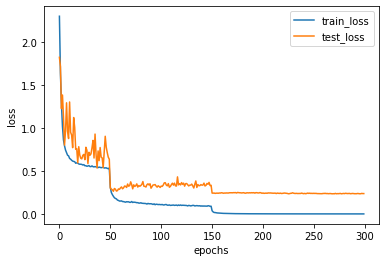

In [ ]:
if __name__ == '__main__':
  evaluate(save="exp_test", lr=0.1, epochs=300,
       scheduler=optim.lr_scheduler.MultiStepLR,
       scheduler_args={'milestones':[50, 150, 250], 'gamma':0.1},
       train_size=50000, valid_size=0, test_size=10000, sampler=MaxSampler(),
       dir="drive/My Drive/ml/exp_vgg19_beta_zero-2020-10-07_12-10-48")

In [ ]:
if __name__ == '__main__':
  evaluate(save="exp_vgg19_maxsampler", lr=0.01, epochs=100,
       scheduler=optim.lr_scheduler.ExponentialLR,
       scheduler_args={'gamma':0.1 ** (1 / 30)},
       train_size=50000, valid_size=0, test_size=10000, sampler=MaxSampler(),
       dir="exp_vgg19_search-2020-10-08_08-43-12")

In [ ]:
if __name__ == '__main__':
  evaluate(save="exp_vgg19_edgewise", lr=0.01, epochs=100,
       scheduler=optim.lr_scheduler.ExponentialLR,
       scheduler_args={'gamma':0.1 ** (1 / 30)},
       train_size=50000, valid_size=0, test_size=10000, sampler=EdgewiseSampler(),
       dir="exp_vgg19_search-2020-10-08_08-43-12")

In [ ]:
if __name__ == '__main__':
  evaluate(save="exp_vgg19_baseline", lr=0.01, epochs=100,
       scheduler=optim.lr_scheduler.ExponentialLR,
       scheduler_args={'gamma':0.1 ** (1 / 30)},
       train_size=50000, valid_size=0, test_size=10000, sampler=ForwardSampler(),
       dir="exp_vgg19_search-2020-10-08_08-43-12")